In [28]:
import os
import numpy as np
import matplotlib.cm as cm
from astropy.io import fits
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from numba import jit

In [130]:
data = Dataset("../data_tenerife_era5/08.nc", mode='r')
lons = data.variables['longitude'][:]
lats = data.variables['latitude'][:]

try:
    T2M = data.variables['tcwv'][:,0,:,:]
except ValueError as verr:
    T2M = data.variables['tcwv'][:,:,:]

var = T2M[:, 10, 20]
var = np.reshape(var,(24, 39*31))

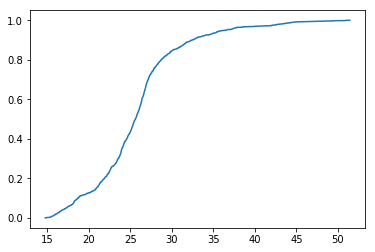

In [131]:
plt.plot(np.sort(var[14,:]), np.linspace(0,1,31*39))

In [50]:
data.variables['expver']

<class 'netCDF4._netCDF4.Variable'>
int32 expver(expver)
    long_name: expver
unlimited dimensions: 
current shape = (2,)
filling on, default _FillValue of -2147483647 used

In [47]:
def shoot(lon, lat, azimuth, maxdist=None):
    """Shooter Function
    Original javascript on http://williams.best.vwh.net/gccalc.htm
    Translated to python by Thomas Lecocq
    """
    glat1 = lat * np.pi / 180.
    glon1 = lon * np.pi / 180.
    s = maxdist / 1.852
    faz = azimuth * np.pi / 180.

    EPS= 0.00000000005
    if ((np.abs(np.cos(glat1))<EPS) and not (np.abs(np.sin(faz))<EPS)):
        alert("Only N-S courses are meaningful, starting at a pole!")

    a=6378.13/1.852
    f=1/298.257223563
    r = 1 - f
    tu = r * np.tan(glat1)
    sf = np.sin(faz)
    cf = np.cos(faz)
    if (cf==0):
        b=0.
    else:
        b=2. * np.arctan2 (tu, cf)

    cu = 1. / np.sqrt(1 + tu * tu)
    su = tu * cu
    sa = cu * sf
    c2a = 1 - sa * sa
    x = 1. + np.sqrt(1. + c2a * (1. / (r * r) - 1.))
    x = (x - 2.) / x
    c = 1. - x
    c = (x * x / 4. + 1.) / c
    d = (0.375 * x * x - 1.) * x
    tu = s / (r * a * c)
    y = tu
    c = y + 1
    while (np.abs (y - c) > EPS):

        sy = np.sin(y)
        cy = np.cos(y)
        cz = np.cos(b + y)
        e = 2. * cz * cz - 1.
        c = y
        x = e * cy
        y = e + e - 1.
        y = (((sy * sy * 4. - 3.) * y * cz * d / 6. + x) *
              d / 4. - cz) * sy * d + tu

    b = cu * cy * cf - su * sy
    c = r * np.sqrt(sa * sa + b * b)
    d = su * cy + cu * sy * cf
    glat2 = (np.arctan2(d, c) + np.pi) % (2*np.pi) - np.pi
    c = cu * cy - su * sy * cf
    x = np.arctan2(sy * sf, c)
    c = ((-3. * c2a + 4.) * f + 4.) * c2a * f / 16.
    d = ((e * cy * c + cz) * sy * c + y) * sa
    glon2 = ((glon1 + x - (1. - c) * d * f + np.pi) % (2*np.pi)) - np.pi	

    baz = (np.arctan2(sa, b) + np.pi) % (2 * np.pi)

    glon2 *= 180./np.pi
    glat2 *= 180./np.pi
    baz *= 180./np.pi

    return (glon2, glat2, baz)

def equi(m, centerlon, centerlat, radius, *args, **kwargs):
    glon1 = centerlon
    glat1 = centerlat
    X = []
    Y = []
    for azimuth in range(0, 360):
        glon2, glat2, baz = shoot(glon1, glat1, azimuth, radius)
        X.append(glon2)
        Y.append(glat2)
    X.append(X[0])
    Y.append(Y[0])

    #~ m.plot(X,Y,**kwargs) #Should work, but doesn't...
    return m(X,Y)

(41,) (21,)
(21, 41)
(21, 41) (21, 41)
(21, 41) (21, 41)


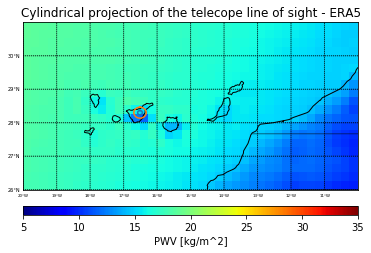

In [48]:
lllong = -20.0
lllat  = 26.0
urlong = -10.0
urlat  = 31.0

mappa = np.median(T2M, axis=0)
m = Basemap(llcrnrlon=lllong, llcrnrlat=lllat, urcrnrlon=urlong, urcrnrlat=urlat, 
            projection='cyl', lon_0=0.0, lat_1=lllat, lat_2=urlat, resolution ='i')

print(np.shape(lons), np.shape(lats))
lon, lat = np.meshgrid(lons, lats)
xi, yi = m(lon, lat)
print(np.shape(mappa))
print(np.shape(lon), np.shape(lat))
print(np.shape(xi), np.shape(yi))


cs = m.pcolor(xi,yi,np.squeeze(mappa[:, :]), vmin=5, vmax=35, cmap=cm.jet)
cs.set_edgecolor('face')
m.drawparallels(np.arange(lllat, urlat, 1.), labels=[1,0,0,0], fontsize=5)
m.drawmeridians(np.arange(lllong, urlong, 1.), labels=[0,0,0,1], fontsize=4)
m.drawcoastlines()
m.drawstates()
m.drawcountries()


cbar = m.colorbar(cs, location='bottom', pad="10%")
cbar.set_label('PWV [kg/m^2]')
cbar.ax.tick_params(labelsize=10)

figure = plt.figure(1)
plt.title('Cylindrical projection of the telecope line of sight - ERA5' )

centerlon = -16.51046
centerlat = 28.30055
X,Y = equi(m, centerlon, centerlat, 7,lw=5.)
X2,Y2 = equi(m, centerlon, centerlat, 18.19,lw=5.)
plt.plot(X, Y, alpha=1, label="Elevation = 70 deg")
plt.plot(X2,Y2, alpha=1, label="Elevation = 40 deg")
figure = plt.figure(1)

plt.savefig("MEDIANA.png", format='png', dpi=360)


In [83]:
np.shape(mappa)

(721, 1440)

In [33]:
np.amin(lons-180)

-180.0

In [50]:
1440/2

720.0

In [59]:
lons[721]-36

-179.75

In [79]:
lons2[0]

-179.75